In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import mlxtend
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pprint import pprint

df = pd.read_csv("C:/Users/owcha/Desktop/application_train.csv")

df = df.iloc[:round(df.shape[0] * 0.3),:]

print('Datashape: ', df.shape)
df.head()

Datashape:  (92253, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Study of missing values.
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values_table(df)


#Rendu compte de nombreuses données manquantes entrée 28 et 44.

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,64285,69.7
COMMONAREA_AVG,64285,69.7
COMMONAREA_MODE,64285,69.7
NONLIVINGAPARTMENTS_MEDI,63862,69.2
NONLIVINGAPARTMENTS_MODE,63862,69.2
...,...,...
EXT_SOURCE_2,201,0.2
AMT_GOODS_PRICE,79,0.1
AMT_ANNUITY,7,0.0
DAYS_LAST_PHONE_CHANGE,1,0.0


In [5]:
#Average of missing values by row.
def missing_values_by_row(df):
    total = 0
    count = 0
    for index, row in df.iterrows():
        for prop in row:
            if not prop:
                count += 1
        total += 1
        
    print( "Each row has about " + str( round(count/total) ) + " missing values." ) 
    
missing_values_by_row(df)

# => To much affected labels for deleting only columns.

Each row has about 38 missing values.


In [6]:
#Study of values type.
print( df.dtypes.value_counts() )

# => 16 labels has dtype object, it needs to be labeled. 
# Also missing values of those 16 columns has hard to transform to numerical values, using average.

float64    65
int64      41
object     16
dtype: int64


In [7]:
#Preprocessing for missing values and bad dtype.

#df = df.dropna(axis=0)

le = LabelEncoder()
le_count = 0

#Fill missing values.
for idx in df.columns:
    if df[idx].dtype == 'object':
        #Fill object missing values can be done by replacing values by the most frequent one or create a new category.
        #pprint ( df[idx].isna().sum() ) # 50% or more of missing data in those columns -> new categories
        df[idx] = df[idx].fillna(value='New categorical label')
    else:
        #Fill numeric missing values can be done by replacing values by the mean or median value of the column.
        df[idx] = df[idx].replace(np.NaN, df[idx].median())

# Labeling
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) >= 1:
            df[col] = le.fit_transform(df[col])
            le_count += 1
print('%d columns were label encoded.' % le_count)

#Dropping useless columns.
useless_cat = [ col for col in df if len(list(df[col].unique())) == 1 ]
for cat in useless_cat:
    df = df.drop(cat, axis=1)
print('%d columns were removed.' % len(useless_cat))


print( missing_values_table(df) )
print('Datashape: ', df.shape)
print( df.dtypes.value_counts() )



16 columns were label encoded.
0 columns were removed.
Your selected dataframe has 122 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []
Datashape:  (92253, 122)
float64    65
int64      41
int32      16
dtype: int64


0    0.919049
1    0.080951
Name: TARGET, dtype: float64


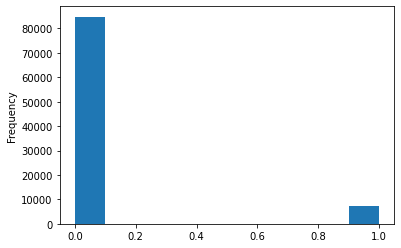

In [8]:
#Dispersion of y study.
print( pd.value_counts(df['TARGET'], normalize=True) )

df['TARGET'].astype(int).plot.hist();

Training data shape:  (169574, 122)


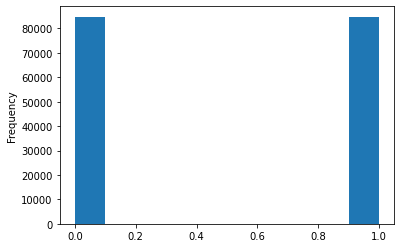

In [9]:
#Oversampling (not undersampling) because we haven't many rows.
# Separate majority and minority classes
df_majority = df[df['TARGET']==0]
df_minority = df[df['TARGET']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=round(df.shape[0] * 0.919089),  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
dfUpsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
dfUpsampled['TARGET'].value_counts()
print('Training data shape: ', dfUpsampled.shape)

dfUpsampled['TARGET'].astype(int).plot.hist();

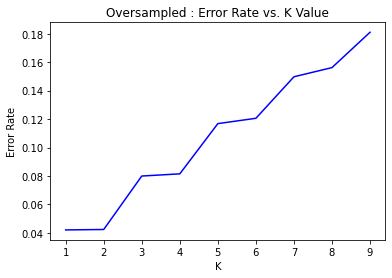

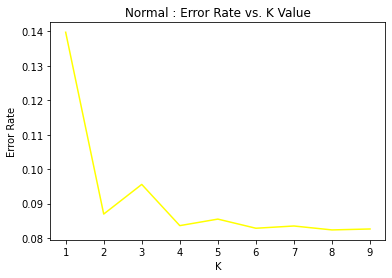

In [12]:
#Knns preparation.

#Oversampled knn.
basic_up_X_train = dfUpsampled.drop('TARGET', 1)
basic_up_y_train = dfUpsampled['TARGET']

#Cross validation for oversampled.
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(basic_up_X_train, basic_up_y_train, test_size=0.2, random_state=0)
up_X_train_id = up_X_train['SK_ID_CURR']
up_X_test_id = up_X_test['SK_ID_CURR']

# Feature scaling for oversampled.
sc = StandardScaler()
up_X_train = pd.DataFrame(sc.fit_transform(up_X_train),columns = up_X_train.columns)
up_X_test = pd.DataFrame(sc.fit_transform(up_X_test),columns = up_X_test.columns)


#Normal knn.
basic_X_train = df.drop('TARGET', 1)
basic_y_train = df['TARGET']

#Cross validation for oversampled.
X_train, X_test, y_train, y_test = train_test_split(basic_X_train, basic_y_train, test_size=0.2, random_state=0)
X_train_id = X_train['SK_ID_CURR']
X_test_id = X_test['SK_ID_CURR']

# Feature scaling for oversampled.
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test),columns = X_test.columns)

#Find the best k for our models.

oversampled_error_rate = []
normal_error_rate = []

for i in range(1,10):
    
    oversampled_knn = KNeighborsClassifier(n_neighbors=i)
    oversampled_knn.fit(up_X_train, up_y_train)
    pred_i = oversampled_knn.predict(up_X_test)
    oversampled_error_rate.append(np.mean(pred_i != up_y_test))
    
    normal_knn = KNeighborsClassifier(n_neighbors=i)
    normal_knn.fit(X_train, y_train)
    pred_i2 = normal_knn.predict(X_test)
    normal_error_rate.append(np.mean(pred_i2 != y_test))


plt.plot(range(1,10),oversampled_error_rate,color='blue', linestyle='solid')
plt.title('Oversampled : Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

plt.plot(range(1,10),normal_error_rate,color='yellow', linestyle='solid')
plt.title('Normal : Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

0.9576293675364883
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     16808
           1       0.92      1.00      0.96     17107

    accuracy                           0.96     33915
   macro avg       0.96      0.96      0.96     33915
weighted avg       0.96      0.96      0.96     33915



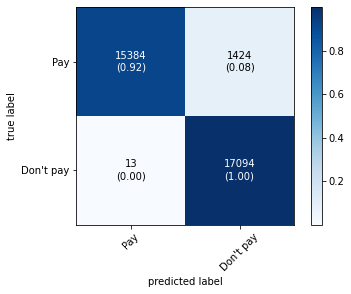

In [109]:
#Oversampled knn declaration -> with k = 2.
oversampled_knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
oversampled_knn.fit(up_X_train, up_y_train)


#Prédiction.
oversampled_pred = oversampled_knn.predict(up_X_test)
oversampled_pred_proba = oversampled_knn.predict_proba(up_X_test)

#Result.
conf_mat = confusion_matrix(up_y_test, oversampled_pred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=["Pay", "Don't pay"])

print ( conf_mat.diagonal().sum()/conf_mat.sum() )

print( classification_report(up_y_test, oversampled_pred))
#The recall means "how many of this class you find over the whole number of element of this class".
#The precision will be "how many are correctly classified among that class".
#The f1-score is the harmonic mean between precision & recall.
#The support is the number of occurence of the given class in your dataset.

#print( accuracy_score(y_test, oversampled_pred) )

In [113]:
#Pickeling
oversampled_pickeled_test = up_X_test[['SK_ID_CURR']].copy()
oversampled_pickeled_test['ID'] = up_X_test_id.tolist()
oversampled_pickeled_test['TARGET'] = oversampled_pred.tolist()
oversampled_pickeled_test['PROBA'] = oversampled_pred_proba.tolist()

print ( oversampled_pickeled_test['ID'] )
print( oversampled_pickeled_test.shape )
oversampled_pickeled_test.head()

oversampled_pickeled_test.to_pickle('my_test.pickle')


0        194194
1        114516
2        152689
3        164011
4        127325
          ...  
33910    197526
33911    141231
33912    134667
33913    194504
33914    137644
Name: ID, Length: 33915, dtype: int64
(33915, 4)


0.9171860603761314
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     16942
           1       0.24      0.01      0.01      1509

    accuracy                           0.92     18451
   macro avg       0.58      0.50      0.48     18451
weighted avg       0.86      0.92      0.88     18451



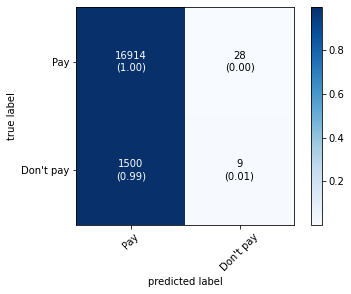

In [112]:
#normal knn declaration -> with k = 6.
normal_knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
normal_knn.fit(X_train, y_train)

#Prédiction.
normal_pred = normal_knn.predict(X_test)

#Result.
conf_mat2 = confusion_matrix(y_test, normal_pred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat2,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=["Pay", "Don't pay"])

print ( conf_mat2.diagonal().sum()/conf_mat2.sum() )

print( classification_report(y_test, normal_pred, zero_division=1))

#print( accuracy_score(y_test, normal_pred) )